In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lish-moa/test_features.csv
/kaggle/input/lish-moa/sample_submission.csv
/kaggle/input/lish-moa/train_features.csv
/kaggle/input/lish-moa/train_targets_scored.csv
/kaggle/input/lish-moa/train_targets_nonscored.csv


In [2]:
# import additional libraries
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots

import random

from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
import tensorflow.keras.models as M
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
import tensorflow_addons as tfa

from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:68: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.2.0 and strictly below 2.3.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.3.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


In [3]:
test_features = pd.read_csv('/kaggle/input/lish-moa/test_features.csv')
train_features = pd.read_csv('/kaggle/input/lish-moa/train_features.csv')
train_targets_scored = pd.read_csv('/kaggle/input/lish-moa/train_targets_scored.csv')
train_targets_nonscored = pd.read_csv('/kaggle/input/lish-moa/train_targets_nonscored.csv')
sample_submission = pd.read_csv('/kaggle/input/lish-moa/sample_submission.csv')

In [4]:
print('Shape training data: ', train_features.shape)
train_features.head()

Shape training data:  (23814, 876)


,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [5]:
print('Shape test data: ', test_features.shape)
test_features.head()

Shape test data:  (3982, 876)


,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_0004d9e33,trt_cp,24,D1,-0.5458,0.1306,-0.5135,0.4408,1.5500,-0.1644,...,0.0981,0.7978,-0.1430,-0.2067,-0.2303,-0.1193,0.0210,-0.0502,0.1510,-0.7750
1,id_001897cda,trt_cp,72,D1,-0.1829,0.2320,1.2080,-0.4522,-0.3652,-0.3319,...,-0.1190,-0.1852,-1.0310,-1.3670,-0.3690,-0.5382,0.0359,-0.4764,-1.3810,-0.7300
2,id_002429b5b,ctl_vehicle,24,D1,0.1852,-0.1404,-0.3911,0.1310,-1.4380,0.2455,...,-0.2261,0.3370,-1.3840,0.8604,-1.9530,-1.0140,0.8662,1.0160,0.4924,-0.1942
3,id_00276f245,trt_cp,24,D2,0.4828,0.1955,0.3825,0.4244,-0.5855,-1.2020,...,0.1260,0.1570,-0.1784,-1.1200,-0.4325,-0.9005,0.8131,-0.1305,0.5645,-0.5809
4,id_0027f1083,trt_cp,48,D1,-0.3979,-1.2680,1.9130,0.2057,-0.5864,-0.0166,...,0.4965,0.7578,-0.1580,1.0510,0.5742,1.0900,-0.2962,-0.5313,0.9931,1.8380


In [6]:
train_targets_scored.head()

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
targets_columns = train_targets_scored.drop(['sig_id'], axis = 1).columns.tolist()

In [8]:
train_targets_scored.shape

(23814, 207)

In [9]:
train_targets_scored.columns.tolist()

['sig_id',
 '5-alpha_reductase_inhibitor',
 '11-beta-hsd1_inhibitor',
 'acat_inhibitor',
 'acetylcholine_receptor_agonist',
 'acetylcholine_receptor_antagonist',
 'acetylcholinesterase_inhibitor',
 'adenosine_receptor_agonist',
 'adenosine_receptor_antagonist',
 'adenylyl_cyclase_activator',
 'adrenergic_receptor_agonist',
 'adrenergic_receptor_antagonist',
 'akt_inhibitor',
 'aldehyde_dehydrogenase_inhibitor',
 'alk_inhibitor',
 'ampk_activator',
 'analgesic',
 'androgen_receptor_agonist',
 'androgen_receptor_antagonist',
 'anesthetic_-_local',
 'angiogenesis_inhibitor',
 'angiotensin_receptor_antagonist',
 'anti-inflammatory',
 'antiarrhythmic',
 'antibiotic',
 'anticonvulsant',
 'antifungal',
 'antihistamine',
 'antimalarial',
 'antioxidant',
 'antiprotozoal',
 'antiviral',
 'apoptosis_stimulant',
 'aromatase_inhibitor',
 'atm_kinase_inhibitor',
 'atp-sensitive_potassium_channel_antagonist',
 'atp_synthase_inhibitor',
 'atpase_inhibitor',
 'atr_kinase_inhibitor',
 'aurora_kinase_inh

In [10]:
# merge train+test
train_features['part'] = 'train'
test_features['part'] = 'test'
train_test = pd.concat([train_features, test_features], ignore_index = True)
train_test

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,part
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176,train
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371,train
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931,train
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154,train
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_ff7004b87,trt_cp,24,D1,0.4571,-0.5743,3.3930,-0.6202,0.8557,1.6240,...,-0.6422,-0.4367,0.0159,-0.6539,-0.4791,-1.2680,-1.1280,-0.4167,-0.6600,test
27792,id_ff925dd0d,trt_cp,24,D1,-0.5885,-0.2548,2.5850,0.3456,0.4401,0.3107,...,0.5780,-0.5888,0.8057,0.9312,1.2730,0.2614,-0.2790,-0.0131,-0.0934,test
27793,id_ffb710450,trt_cp,72,D1,-0.3985,-0.1554,0.2677,-0.6813,0.0152,0.4791,...,0.9153,-0.1862,0.4049,0.9568,0.4666,0.0461,0.5888,-0.4205,-0.1504,test
27794,id_ffbb869f2,trt_cp,48,D2,-1.0960,-1.7750,-0.3977,1.0160,-1.3350,-0.2207,...,-0.4473,-0.8192,0.7785,0.3133,0.1286,-0.2618,0.5074,0.7430,-0.0484,test


## EDA

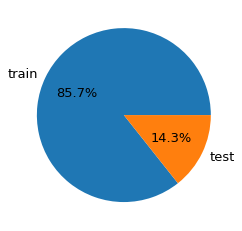

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(15,4))
ax.pie([train_features.shape[0], test_features.shape[0]], autopct='%1.1f%%', labels = ['train', 'test'], textprops={'fontsize': 13})
plt.show()

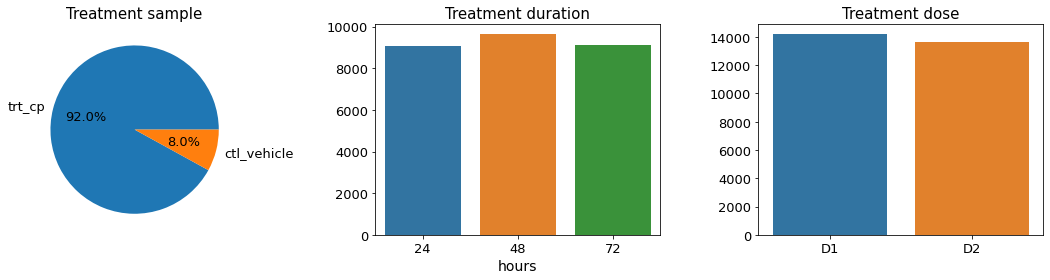

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,4))
ax1.pie(train_test['cp_type'].value_counts(), autopct='%1.1f%%', labels = ['trt_cp', 'ctl_vehicle'], textprops={'fontsize': 13})
ax1.set_title('Treatment sample', fontsize=15)
b=sns.countplot(train_test['cp_time'], ax=ax2)
b.tick_params(labelsize=13)
ax2.set_title('Treatment duration', fontsize=15)
ax2.set_xlabel('hours', fontsize=14)
ax2.set_ylabel('')
b=sns.countplot(train_test['cp_dose'], ax=ax3)
b.tick_params(labelsize=13)
ax3.set_title('Treatment dose', fontsize=15)
ax3.set_xlabel('', fontsize=14)
ax3.set_ylabel('')
fig.tight_layout()
plt.show()

Treatment durations and doses are quite balanced...

### Feature distributions

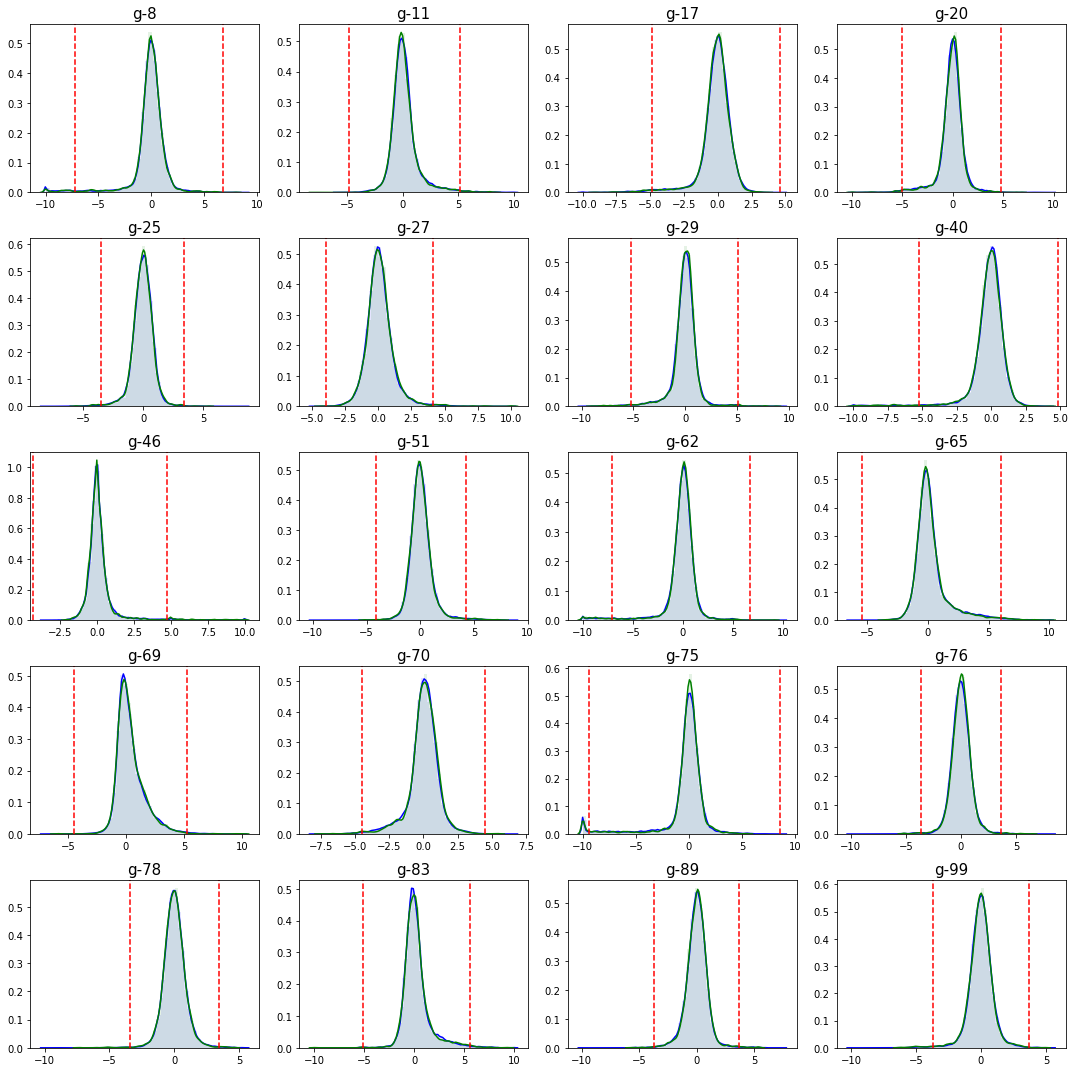

In [13]:
fig, axes = plt.subplots(ncols=4, nrows=5, figsize = (15, 15))

plot_std = 4
randplots = np.sort(random.sample(range(100), 20))
for i, ax in zip(range(len(randplots)), axes.flat):
    
    sns.distplot(train_features['g-' + str(randplots[i])], ax = ax, color="b", hist_kws=dict(alpha=0.1))
    sns.distplot(test_features['g-' + str(randplots[i])], ax = ax, color="g", hist_kws=dict(alpha=0.1))
    ax.axvline(x=np.mean(train_features['g-' + str(randplots[i])])-plot_std*np.std(train_features['g-' + str(randplots[i])]), color='r', linestyle='--')
    ax.axvline(x=np.mean(train_features['g-' + str(randplots[i])])+plot_std*np.std(train_features['g-' + str(randplots[i])]), color='r', linestyle='--')
    ax.set_title('g-' + str(randplots[i]), fontsize=15)
    ax.set_xlabel('')
    
fig.tight_layout()
plt.show()

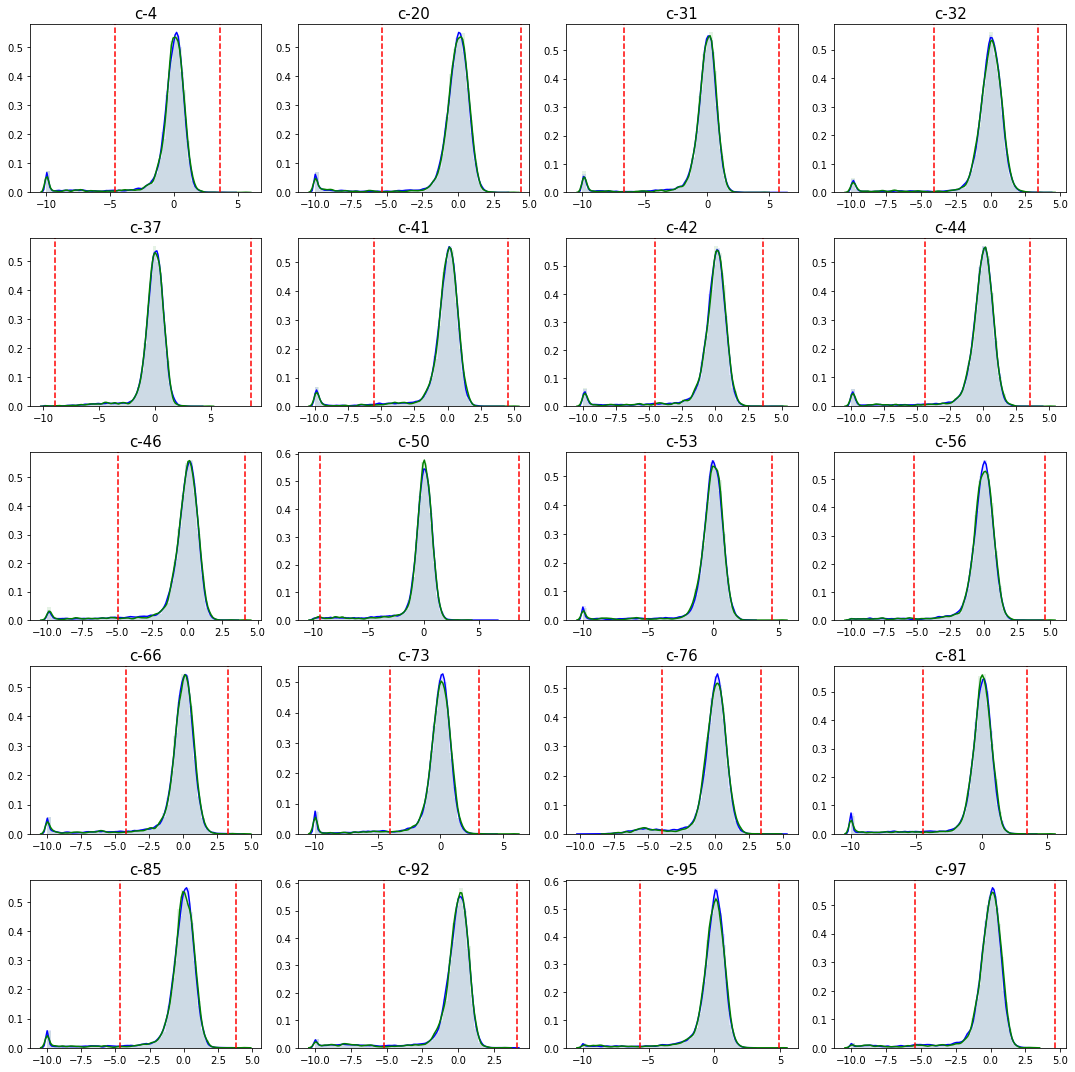

In [14]:
fig, axes = plt.subplots(ncols=4, nrows=5, figsize = (15, 15))

randplots = np.sort(random.sample(range(100), 20))
for i, ax in zip(range(len(randplots)), axes.flat):
    
    sns.distplot(train_features['c-' + str(randplots[i])], ax = ax, color="b", hist_kws=dict(alpha=0.1))
    sns.distplot(test_features['c-' + str(randplots[i])], ax = ax, color="g", hist_kws=dict(alpha=0.1))
    ax.axvline(x=np.mean(train_features['c-' + str(randplots[i])])-plot_std*np.std(train_features['g-' + str(randplots[i])]), color='r', linestyle='--')
    ax.axvline(x=np.mean(train_features['c-' + str(randplots[i])])+plot_std*np.std(train_features['g-' + str(randplots[i])]), color='r', linestyle='--')
    ax.set_title('c-' + str(randplots[i]), fontsize=15)
    ax.set_xlabel('')
    
fig.tight_layout()
plt.show()

- gene expression + cell viability mostly follow normal distribution centered at zero, with some right-skewed distributions
- often presence of long tails, especially for cell viability. Accumulation of outliers at -10
- train + testing distributions are very close

### Correlation: Gene expression

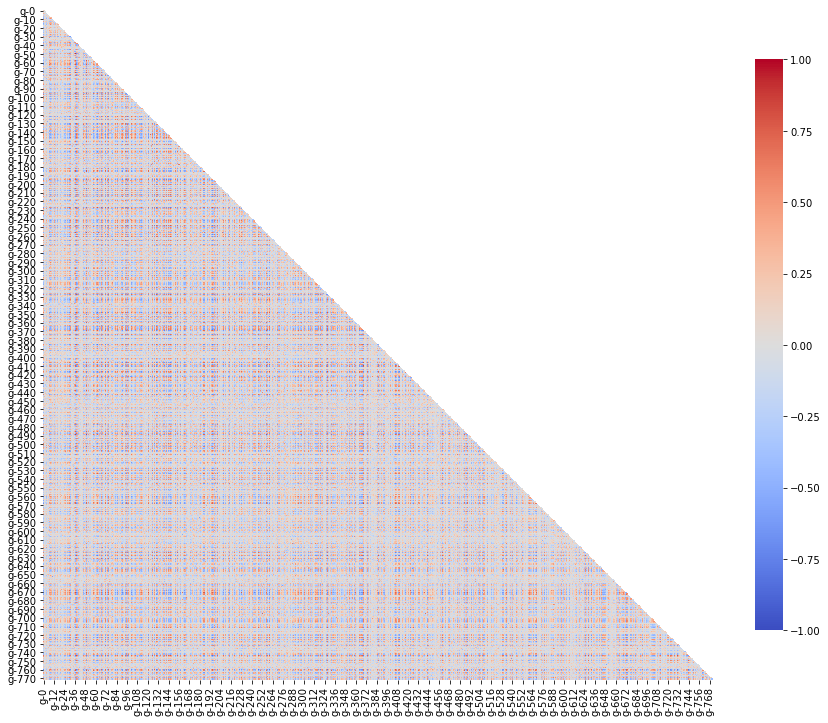

In [15]:
gene_cols = [col for col in train_features if col.startswith('g-')]
corr = train_features[gene_cols].corr(method='pearson')
mask = np.triu(np.ones_like(corr, dtype=bool))
fig = plt.figure(figsize = (15, 15))
sns.heatmap(corr,vmin=-1, vmax=1, center=0,
    #cmap=sns.diverging_palette(20, 220, n=200),
    cmap='coolwarm',
    square=True,
    cbar_kws={"shrink": 0.7},
    mask=mask
    )
plt.show()

-> Some gene expression features are correlated with each other

### Correlation: Cell viability

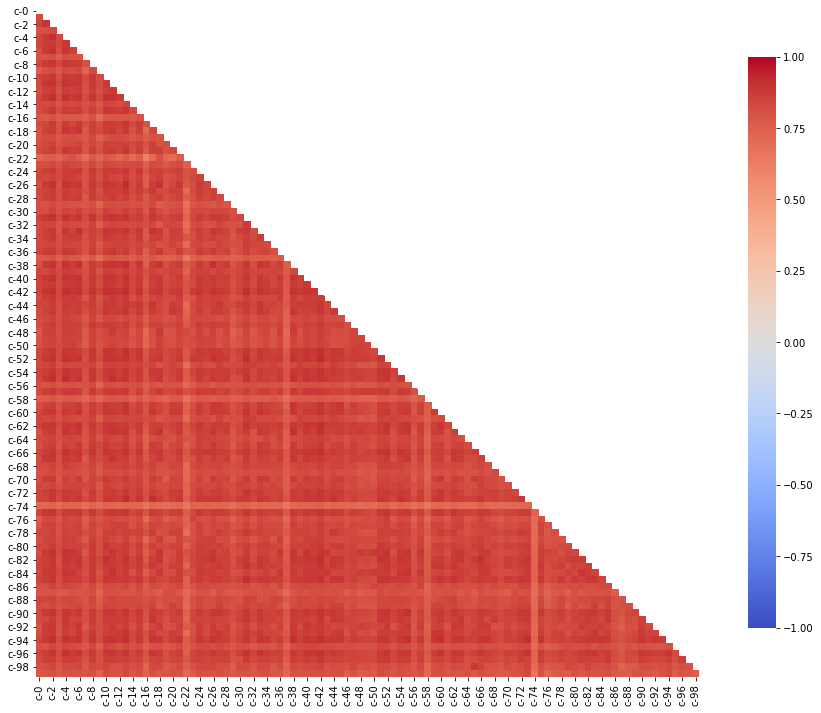

In [16]:
cell_cols = [col for col in train_features if col.startswith('c-')]
corr = train_features[cell_cols].corr(method='pearson')
mask = np.triu(np.ones_like(corr, dtype=bool))
fig = plt.figure(figsize = (15, 15))
sns.heatmap(corr,vmin=-1, vmax=1, center=0,
    #cmap=sns.diverging_palette(20, 220, n=200),
    cmap='coolwarm',
    square=True,
    cbar_kws={"shrink": 0.7},
    mask=mask
    )
plt.show()

-> cell viability features are overall highly correlated to each other

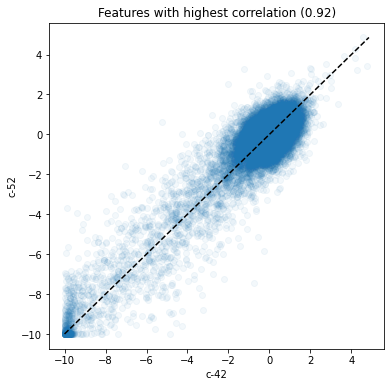

In [17]:
# Show example where the correlation is highest
s = corr.unstack()
so = s.sort_values(kind="quicksort",ascending=False)
feature1 = so[so!=1].head(1).index[0][0]
feature2 = so[so!=1].head(1).index[0][1]
minn=np.min([train_features[feature1], train_features[feature2]])
maxx=np.max([train_features[feature1], train_features[feature2]])
maxcorr = so[so!=1][0]
fig = plt.figure(figsize = (6, 6))
b=plt.scatter(train_features[feature1], train_features[feature2], alpha=0.05)
plt.plot( [minn,maxx],[minn,maxx], '--k')
plt.xlabel(so[so!=1].head(1).index[0][0])
plt.ylabel(so[so!=1].head(1).index[0][1])
plt.title('Features with highest correlation (' + str(round(maxcorr, 2)) + ')')
plt.rcParams.update({'font.size': 12})
plt.show()

### Correlation: gene experession & Cell viability

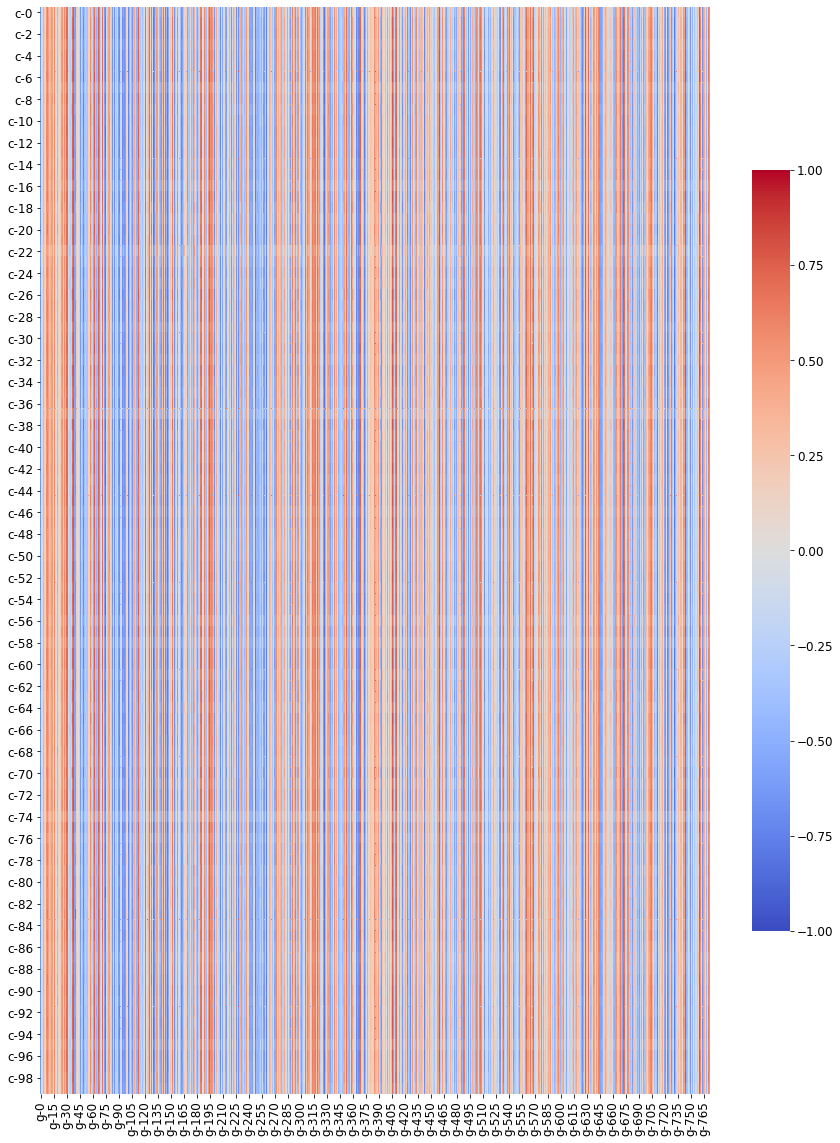

In [18]:
fig = plt.figure(figsize = (15, 20))
corr = train_features[cell_cols + gene_cols].corr(method='pearson')
sns.heatmap(corr.loc[cell_cols, gene_cols],vmin=-1, vmax=1, center=0,
    cmap='coolwarm',
    cbar_kws={"shrink": 0.7}
    )
plt.show()

-> Some gene features correlate with *every* cell viability feature

### Target occurrences

In [19]:
target_count = train_targets_scored.set_index('sig_id').sum().sort_values().to_frame()
target_count.reset_index(inplace=True)
target_count.columns = ['Action','Sum']
target_count

,Action,Sum
0,atp-sensitive_potassium_channel_antagonist,1
1,erbb2_inhibitor,1
2,diuretic,6
3,autotaxin_inhibitor,6
4,protein_phosphatase_inhibitor,6
...,...,...
201,serotonin_receptor_antagonist,404
202,dopamine_receptor_antagonist,424
203,cyclooxygenase_inhibitor,435
204,proteasome_inhibitor,726


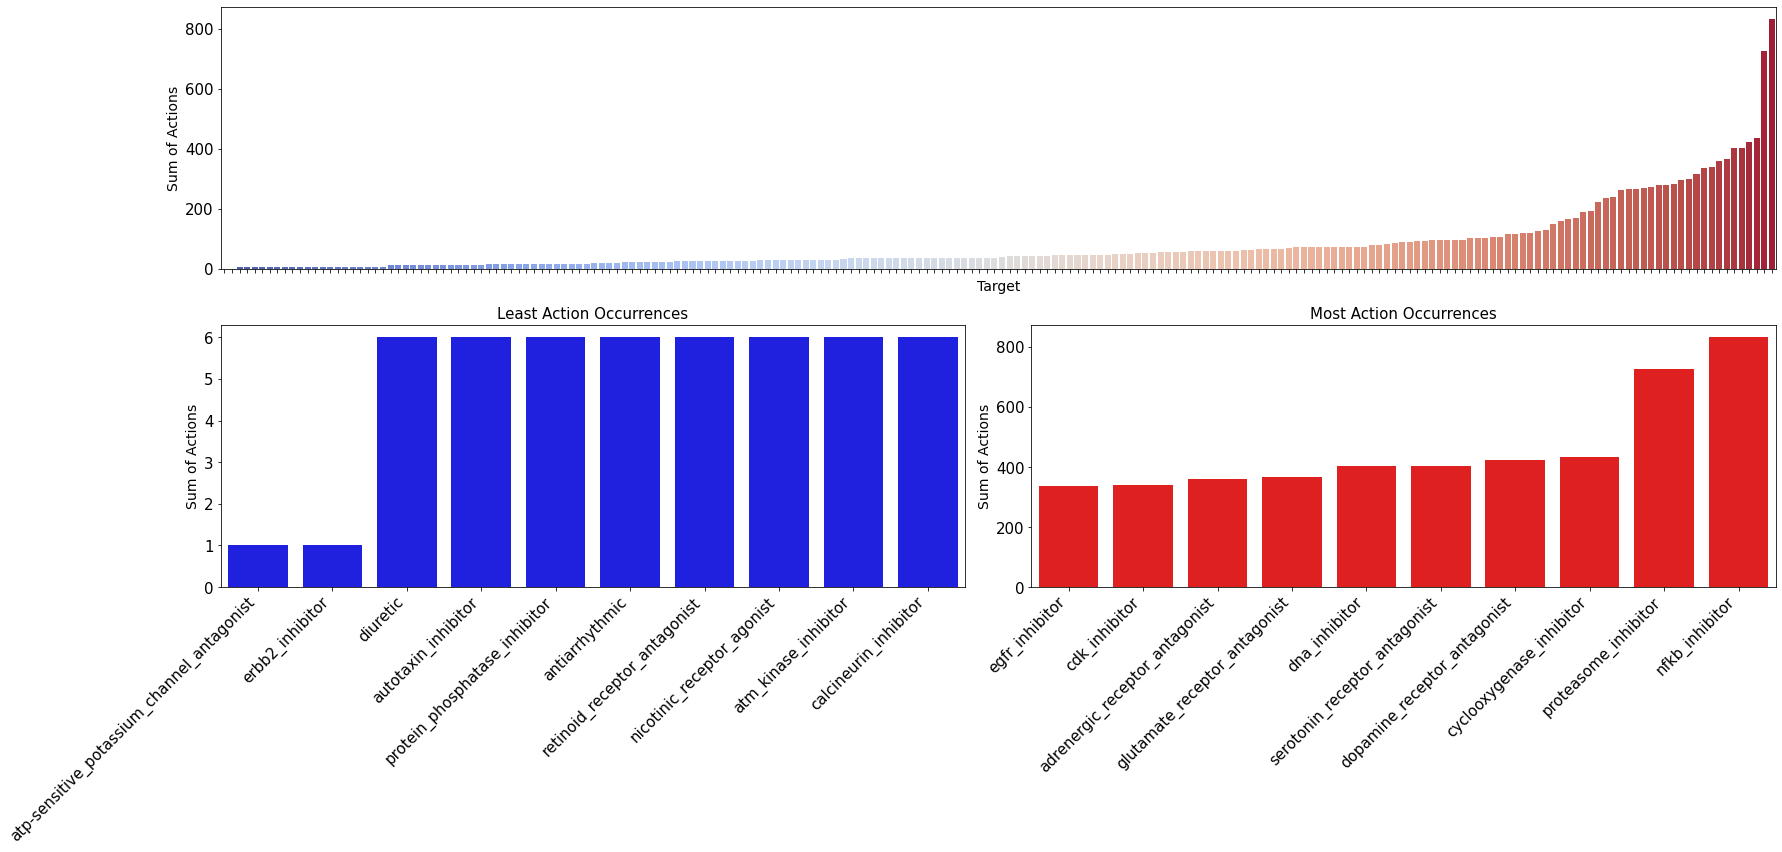

In [20]:
fig = plt.figure(figsize = (25, 12))
ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
p1=sns.barplot(y='Sum',x='Action',data=target_count, palette="coolwarm", ax=ax1)
p1.tick_params(labelsize=15)
p1.set_xlabel('Target', fontsize=14)
p1.set_ylabel('Sum of Actions', fontsize=14)
p1.set_xticklabels(['']*target_count.shape[0])

ax2 = plt.subplot2grid((2, 2), (1, 0))
p2=sns.barplot(y='Sum',x='Action',data=target_count.head(10), color='blue', ax=ax2)
p2.set_xticklabels(p2.get_xticklabels(), rotation = 45, ha='right')
p2.tick_params(labelsize=15)
p2.set_title('Least Action Occurrences', fontsize=15)
p2.set_xlabel('')
p2.set_ylabel('Sum of Actions', fontsize=14)

ax3 = plt.subplot2grid((2, 2), (1, 1))
p3=sns.barplot(y='Sum',x='Action',data=target_count.tail(10), color='red', ax=ax3)
p3.set_xticklabels(p3.get_xticklabels(), rotation = 45, ha='right')
p3.tick_params(labelsize=15)
p3.set_title('Most Action Occurrences', fontsize=15)
p3.set_xlabel('')
p3.set_ylabel('Sum of Actions', fontsize=14)

fig.tight_layout()
plt.show()

Two targets have by far most actions, with the majority of targets having few (< ~50) actions. It might be that some of these are redundant with other targets.
'atp-sensitive_potassium_channel_antagonist' and 'erbb2_inhibitor' have only 1 action, so it might be better to set their columns to 0 later

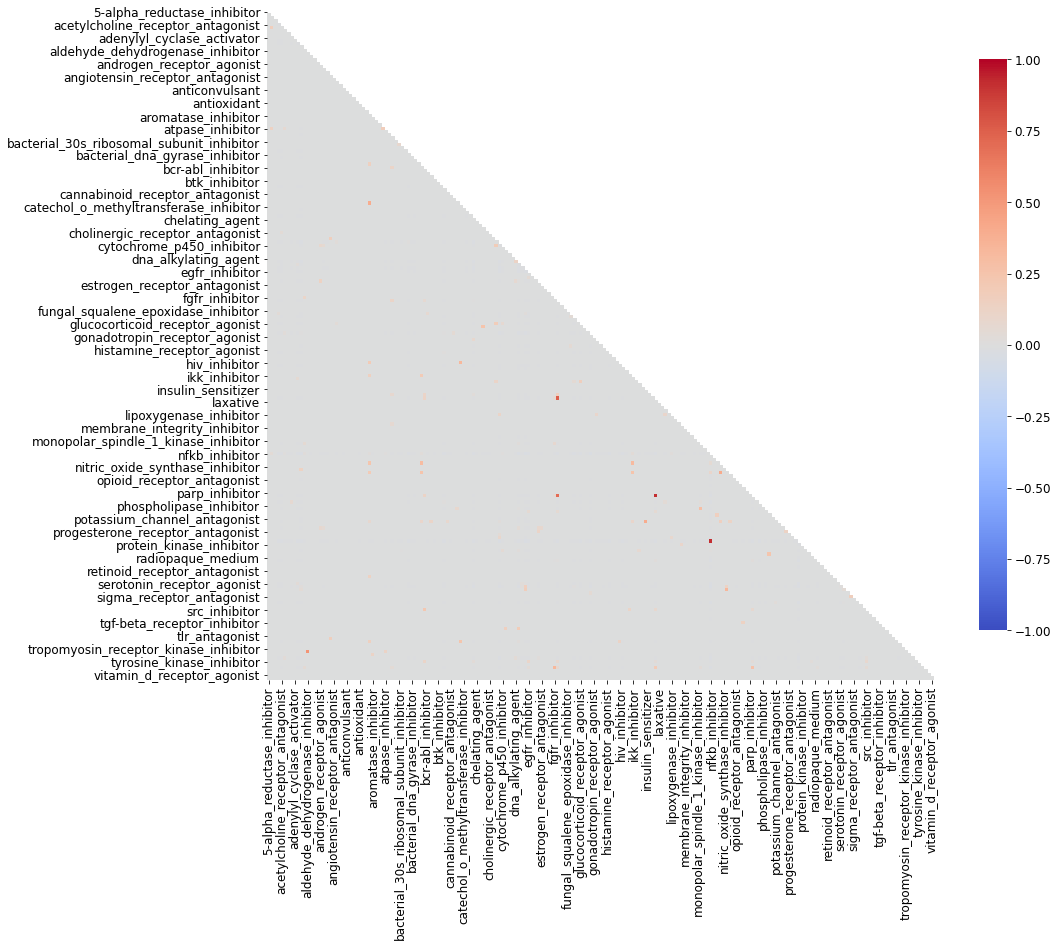

In [21]:
corr = train_targets_scored.set_index('sig_id').corr(method='pearson')
mask = np.triu(np.ones_like(corr, dtype=bool))
fig = plt.figure(figsize = (15, 15))
sns.heatmap(corr,vmin=-1, vmax=1, center=0,
    #cmap=sns.diverging_palette(20, 220, n=200),
    cmap='coolwarm',
    square=True,
    cbar_kws={"shrink": 0.7},
    mask=mask
    )
plt.show()

-> There are no correlations between targets (with very rare exceptions)

## Preprocessing

In [22]:
# NEW Turn values for highly imbalanced targets to zero
train_targets_scored['atp-sensitive_potassium_channel_antagonist'] = 0
train_targets_scored['erbb2_inhibitor'] = 0

### PCA

As numerical features, especially cell viability, are highly correlated, apply some dimensionality reduction. 

In [23]:
# z-transform data and remove outliers
numcols=train_test._get_numeric_data().columns
all_data_num=train_test.loc[:,numcols].drop(['cp_time'], axis=1)
all_data_num=all_data_num.apply(stats.zscore)

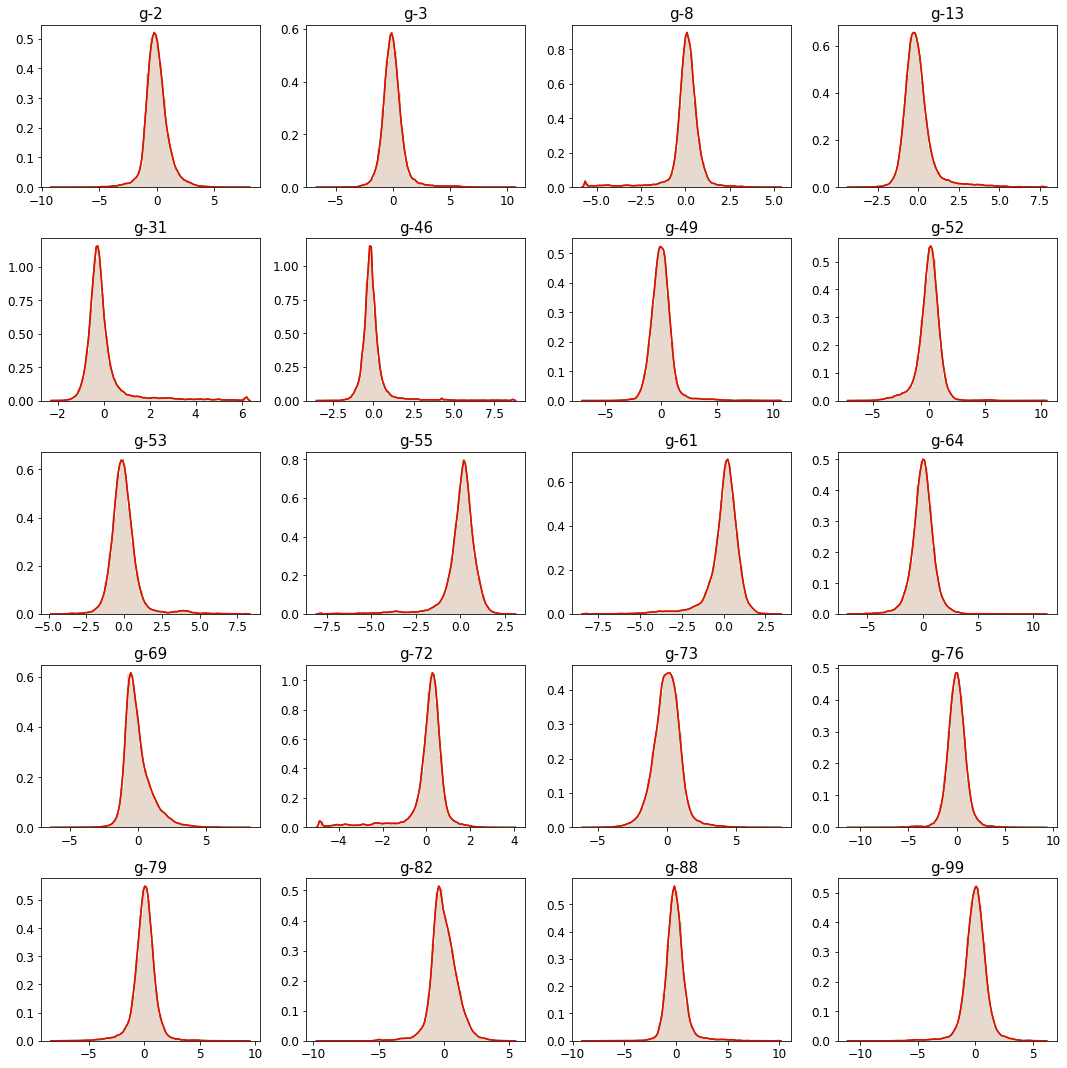

In [24]:
fig, axes = plt.subplots(ncols=4, nrows=5, figsize = (15, 15))

randplots = np.sort(random.sample(range(100), 20))
for i, ax in zip(range(len(randplots)), axes.flat):
    
    sns.distplot(all_data_num['g-' + str(randplots[i])], ax = ax, color="g", hist_kws=dict(alpha=0.1))
    sns.distplot(all_data_num['g-' + str(randplots[i])], ax = ax, color="r", hist_kws=dict(alpha=0.1))
    ax.set_title('g-' + str(randplots[i]), fontsize=15)
    ax.set_xlabel('')
    
fig.tight_layout()
plt.show()

In [25]:
def apply_PCA(df, features, ncomponents):
    
    # Separating out the features
    x = train_test.loc[:, features].values# Separating out the target
    x = StandardScaler().fit_transform(x)
    
    pca = PCA(n_components=ncomponents)
    principalComponents = pca.fit_transform(x)
    
    return principalComponents, pca

In [26]:
ncomps_genes = 50
ncomps_cells = 20
principalComponents_gene, pca_gene = apply_PCA(train_test, gene_cols, ncomps_genes)
principalComponents_cell, pca_cell = apply_PCA(train_test, cell_cols, ncomps_cells)

In [27]:
df_pca_gene = pd.DataFrame(principalComponents_gene, columns=[f'pca_G-{i}' for i in range(ncomps_genes)])
df_pca_cell = pd.DataFrame(principalComponents_cell, columns=[f'pca_C-{i}' for i in range(ncomps_cells)])
train_test = pd.concat((train_test, df_pca_gene), axis=1)
train_test = pd.concat((train_test, df_pca_cell), axis=1)
train_test

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,pca_C-10,pca_C-11,pca_C-12,pca_C-13,pca_C-14,pca_C-15,pca_C-16,pca_C-17,pca_C-18,pca_C-19
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,-0.548408,0.133462,0.027225,0.059741,-0.397772,0.392125,-0.025301,-0.381506,-0.293763,0.272850
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,0.411966,0.701580,0.152064,0.332867,0.243619,0.284303,0.002241,-0.180133,-0.494316,0.203909
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.141941,0.121380,0.138807,0.449701,0.604613,0.184671,0.567881,0.156045,0.252755,0.000165
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,0.684961,0.269521,-0.225517,0.046389,0.756118,-0.130553,0.337098,0.216955,0.333326,0.389694
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.164000,0.459642,-0.013426,-0.254156,0.161142,-0.117424,0.122907,0.544709,0.089210,0.016670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_ff7004b87,trt_cp,24,D1,0.4571,-0.5743,3.3930,-0.6202,0.8557,1.6240,...,-0.032352,-0.294431,0.386380,0.281015,-0.338875,-0.074451,0.151849,0.195056,-0.535606,0.047511
27792,id_ff925dd0d,trt_cp,24,D1,-0.5885,-0.2548,2.5850,0.3456,0.4401,0.3107,...,0.638734,0.545261,0.316088,0.038887,0.016008,-0.181934,-0.359586,0.161388,0.603409,1.069255
27793,id_ffb710450,trt_cp,72,D1,-0.3985,-0.1554,0.2677,-0.6813,0.0152,0.4791,...,-0.403002,-0.405384,0.639913,0.432709,0.098111,0.059816,0.362296,0.354797,-0.039568,-0.129487
27794,id_ffbb869f2,trt_cp,48,D2,-1.0960,-1.7750,-0.3977,1.0160,-1.3350,-0.2207,...,-0.872555,0.107753,-0.107638,0.353305,-0.212662,0.057512,-0.249642,0.209229,-0.115517,0.226806


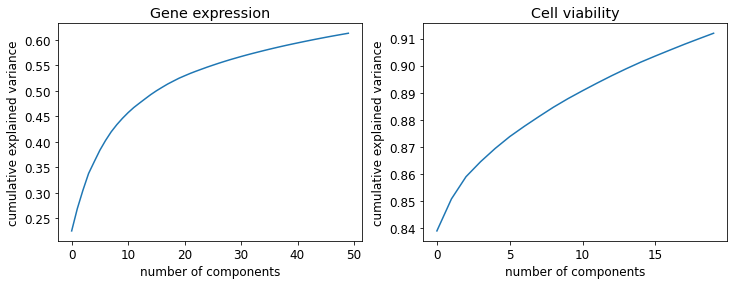

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
ax1.plot(np.cumsum(pca_gene.explained_variance_ratio_))
ax1.set_xlabel('number of components')
ax1.set_ylabel('cumulative explained variance');
ax1.set_title('Gene expression')

ax2.plot(np.cumsum(pca_cell.explained_variance_ratio_))
ax2.set_xlabel('number of components')
ax2.set_ylabel('cumulative explained variance');
ax2.set_title('Cell viability')

plt.show()

In [29]:
# label-encoding
train_test.loc[:, 'cp_type'] = train_test.loc[:, 'cp_type'].map({'trt_cp': 0, 'ctl_vehicle': 1})
train_test.loc[:, 'cp_dose'] = train_test.loc[:, 'cp_dose'].map({'D1': 0, 'D2': 1})
train_test

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,pca_C-10,pca_C-11,pca_C-12,pca_C-13,pca_C-14,pca_C-15,pca_C-16,pca_C-17,pca_C-18,pca_C-19
0,id_000644bb2,0,24,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,-0.548408,0.133462,0.027225,0.059741,-0.397772,0.392125,-0.025301,-0.381506,-0.293763,0.272850
1,id_000779bfc,0,72,0,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,0.411966,0.701580,0.152064,0.332867,0.243619,0.284303,0.002241,-0.180133,-0.494316,0.203909
2,id_000a6266a,0,48,0,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.141941,0.121380,0.138807,0.449701,0.604613,0.184671,0.567881,0.156045,0.252755,0.000165
3,id_0015fd391,0,48,0,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,0.684961,0.269521,-0.225517,0.046389,0.756118,-0.130553,0.337098,0.216955,0.333326,0.389694
4,id_001626bd3,0,72,1,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.164000,0.459642,-0.013426,-0.254156,0.161142,-0.117424,0.122907,0.544709,0.089210,0.016670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_ff7004b87,0,24,0,0.4571,-0.5743,3.3930,-0.6202,0.8557,1.6240,...,-0.032352,-0.294431,0.386380,0.281015,-0.338875,-0.074451,0.151849,0.195056,-0.535606,0.047511
27792,id_ff925dd0d,0,24,0,-0.5885,-0.2548,2.5850,0.3456,0.4401,0.3107,...,0.638734,0.545261,0.316088,0.038887,0.016008,-0.181934,-0.359586,0.161388,0.603409,1.069255
27793,id_ffb710450,0,72,0,-0.3985,-0.1554,0.2677,-0.6813,0.0152,0.4791,...,-0.403002,-0.405384,0.639913,0.432709,0.098111,0.059816,0.362296,0.354797,-0.039568,-0.129487
27794,id_ffbb869f2,0,48,1,-1.0960,-1.7750,-0.3977,1.0160,-1.3350,-0.2207,...,-0.872555,0.107753,-0.107638,0.353305,-0.212662,0.057512,-0.249642,0.209229,-0.115517,0.226806


## Training

In [30]:
# select features to train on
#train_features = cell_cols + gene_cols + ['cp_type', 'cp_time', 'cp_dose']
train_features = df_pca_gene.columns.tolist() + df_pca_cell.columns.tolist() + ['cp_type', 'cp_time', 'cp_dose']

In [31]:
train_test_scored = pd.merge(train_test, train_targets_scored, how='inner')
train_test_scored

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0,24,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,72,0,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,48,0,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,48,0,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,72,1,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23809,id_fffb1ceed,0,24,1,0.1394,-0.0636,-0.1112,-0.5080,-0.4713,0.7201,...,0,0,0,0,0,0,0,0,0,0
23810,id_fffb70c0c,0,24,1,-1.3260,0.3478,-0.3743,0.9905,-0.7178,0.6621,...,0,0,0,0,0,0,0,0,0,0
23811,id_fffc1c3f4,1,48,1,0.3942,0.3756,0.3109,-0.7389,0.5505,-0.0159,...,0,0,0,0,0,0,0,0,0,0
23812,id_fffcb9e7c,0,24,0,0.6660,0.2324,0.4392,0.2044,0.8531,-0.0343,...,0,0,0,0,0,0,0,0,0,0


In [32]:
train = train_test_scored[train_features]
target = train_test_scored[targets_columns]

### Random Forests

In [33]:
'''
#Split data into train and test datasets
X_train,X_test,Y_train,Y_test=train_test_split(train, target,test_size=0.3,random_state=1)
rf = RandomForestClassifier(n_estimators=200,max_depth=10, random_state=0,min_samples_split=10)
rf.fit(X_train,Y_train)#Fitting the model 

#Generating predictions from Random Forest Models
pred_rf=rf.predict(X_test)
pred_rf_proba=rf.predict_proba(X_test)

feat_importances = pd.Series(rf.feature_importances_, index=train_features)
feat_importances=feat_importances.sort_values()
feat_importances.plot(kind='barh',figsize=(16,16))#Plotting feature importance

print('Model Accuracy')
print(rf.score(X_test,Y_test))
'''

"\n#Split data into train and test datasets\nX_train,X_test,Y_train,Y_test=train_test_split(train, target,test_size=0.3,random_state=1)\nrf = RandomForestClassifier(n_estimators=200,max_depth=10, random_state=0,min_samples_split=10)\nrf.fit(X_train,Y_train)#Fitting the model \n\n#Generating predictions from Random Forest Models\npred_rf=rf.predict(X_test)\npred_rf_proba=rf.predict_proba(X_test)\n\nfeat_importances = pd.Series(rf.feature_importances_, index=train_features)\nfeat_importances=feat_importances.sort_values()\nfeat_importances.plot(kind='barh',figsize=(16,16))#Plotting feature importance\n\nprint('Model Accuracy')\nprint(rf.score(X_test,Y_test))\n"

### Neural Networks

In [34]:
def create_nnmodel(nfeatures):
    '''
    model = tf.keras.Sequential([
    tf.keras.layers.Input(nfeatures),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tfa.layers.WeightNormalization(tf.keras.layers.Dense(2048, activation="relu")),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tfa.layers.WeightNormalization(tf.keras.layers.Dense(1048, activation="relu")),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tfa.layers.WeightNormalization(tf.keras.layers.Dense(206, activation="sigmoid"))
    ])
    '''
    model = tf.keras.Sequential([
    tf.keras.layers.Input(nfeatures),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tfa.layers.WeightNormalization(tf.keras.layers.Dense(2048, activation="relu")),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tfa.layers.WeightNormalization(tf.keras.layers.Dense(1048, activation="relu")),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tfa.layers.WeightNormalization(tf.keras.layers.Dense(1048, activation="relu")),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tfa.layers.WeightNormalization(tf.keras.layers.Dense(206, activation="sigmoid"))
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics=["accuracy", "AUC"])
    return model

In [35]:
def train_kfold(train_values, target_values, BATCH_SIZE, NEPOCHS, NFOLDS):
    
    acc_per_fold_train = []
    loss_per_fold_train = []
    acc_per_fold_val = []
    loss_per_fold_val = []
    
    kf = KFold(n_splits=NFOLDS, shuffle=True)

    predictions_test = np.zeros((test_features.shape[0], len(targets_columns)))
    to_predict=train_test[train_test['part']=='test'][train_features]
    
    loss_training_per_fold = np.zeros((NFOLDS, NEPOCHS))
    loss_validation_per_fold = np.zeros((NFOLDS, NEPOCHS))

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, mode='min', verbose=1)

    ifold = 1
    for train_idx, val_idx in kf.split(train):
        
        print(f'****************************** Fold {ifold} ...******************************')
        
        nn = create_nnmodel(train_values.shape[1])
        history = nn.fit(train_values[train_idx], target_values[train_idx], batch_size=BATCH_SIZE, epochs=NEPOCHS, callbacks=[reduce_lr], validation_data=(train_values[val_idx], target_values[val_idx]), verbose=0)

        # Generate generalization metrics
        scores_train = nn.evaluate(train_values[train_idx], target_values[train_idx], batch_size=BATCH_SIZE, verbose=0)
        print(f'Training score: {nn.metrics_names[0]} of {scores_train[0]}; {nn.metrics_names[1]} of {scores_train[1]*100}%')
        acc_per_fold_train.append(scores_train[1] * 100)
        loss_per_fold_train.append(scores_train[0])

        scores_val = nn.evaluate(train_values[val_idx], target_values[val_idx], batch_size=BATCH_SIZE, verbose=0)
        print(f'Validation score: {nn.metrics_names[0]} of {scores_val[0]}; {nn.metrics_names[1]} of {scores_val[1]*100}%')
        acc_per_fold_val.append(scores_val[1] * 100)
        loss_per_fold_val.append(scores_val[0])

        loss_training_per_fold[ifold-1, :] = np.array(history.history['loss'])
        loss_validation_per_fold[ifold-1, :] = np.array(history.history['val_loss'])

        predictions_test+= nn.predict(to_predict, batch_size=BATCH_SIZE) / NFOLDS

        ifold+=1

    # == Provide average scores ==
    print('------------------------------------------------------------------------')
    print('Score per fold')
    for i in range(0, len(acc_per_fold_train)):
        print('------------------------------------------------------------------------')
        print(f'> Fold {i+1}, Training - Loss: {loss_per_fold_train[i]} - Accuracy: {acc_per_fold_train[i]}%')
        print(f'> Fold {i+1}, Validation - Loss: {loss_per_fold_val[i]} - Accuracy: {acc_per_fold_val[i]}%')
    print('------------------------------------------------------------------------')
    print('Average scores for all folds:')
    print(f'> Accuracy Training: {np.mean(acc_per_fold_train)} (+- {np.std(acc_per_fold_train)})')
    print(f'> Accuracy Validation: {np.mean(acc_per_fold_val)} (+- {np.std(acc_per_fold_val)})')
    print(f'> Loss Training: {np.mean(loss_per_fold_train)}')
    print(f'> Loss Validation: {np.mean(loss_per_fold_val)}')
    print('------------------------------------------------------------------------')
    
    # summarize history for loss
    fig, ax = plt.subplots(figsize=(10, 5))
    plt.plot(np.log(np.mean(loss_training_per_fold, axis=0)))
    plt.plot(np.log(np.mean(loss_validation_per_fold, axis=0)))
    plt.title(f'Mean model loss across folds', fontsize=15)
    plt.ylabel('log loss', fontsize=15)
    plt.xlabel('epoch', fontsize=15)
    plt.legend(['train', 'validation'], loc='upper right')
    ax.tick_params(labelsize=12)
    plt.show()
    
    return predictions_test

-----------------------------------------------------------------------
####################### Training for seed 1 ... #######################
****************************** Fold 1 ...******************************

Epoch 00034: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 00039: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.

Epoch 00045: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.

Epoch 00048: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.
Training score: loss of 0.014772825874388218; accuracy of 13.694819808006287%
Validation score: loss of 0.015789790078997612; accuracy of 11.0224649310112%
****************************** Fold 2 ...******************************

Epoch 00038: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 00042: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.

Epoch 00045: ReduceLROnPlateau reducing learning rate to 8.00000

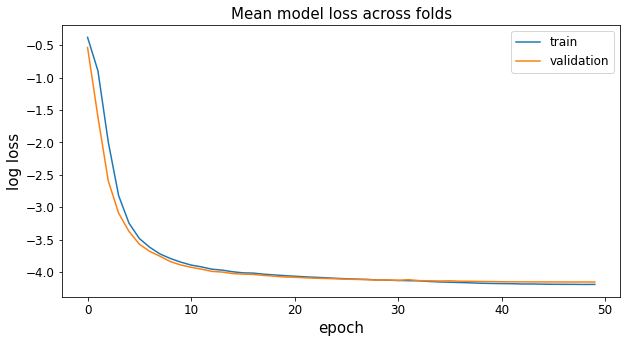

-----------------------------------------------------------------------
####################### Training for seed 2 ... #######################
****************************** Fold 1 ...******************************

Epoch 00038: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 00042: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.

Epoch 00045: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.

Epoch 00048: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.
Training score: loss of 0.014329112134873867; accuracy of 14.440186321735382%
Validation score: loss of 0.015527780167758465; accuracy of 12.555111944675446%
****************************** Fold 2 ...******************************

Epoch 00027: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 00034: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.

Epoch 00037: ReduceLROnPlateau reducing learning rate to 8.000

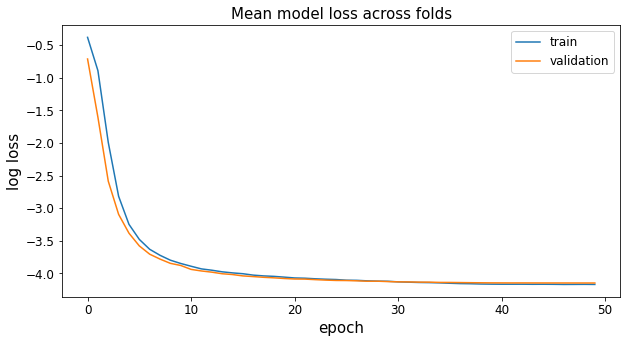

-----------------------------------------------------------------------
####################### Training for seed 3 ... #######################
****************************** Fold 1 ...******************************

Epoch 00041: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 00044: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.

Epoch 00050: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
Training score: loss of 0.013943654485046864; accuracy of 16.046401858329773%
Validation score: loss of 0.015719536691904068; accuracy of 12.156204134225845%
****************************** Fold 2 ...******************************

Epoch 00039: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 00043: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.

Epoch 00046: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.

Epoch 00049: ReduceLROnPlateau reducing learning rate to 1.6000

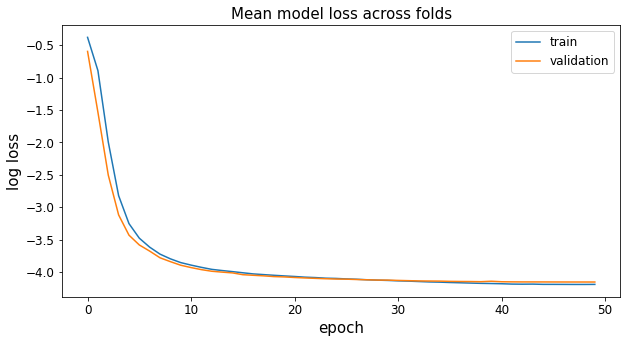

-----------------------------------------------------------------------
####################### Training for seed 4 ... #######################
****************************** Fold 1 ...******************************

Epoch 00032: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 00037: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.

Epoch 00043: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.

Epoch 00046: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.

Epoch 00049: ReduceLROnPlateau reducing learning rate to 3.200000264769187e-07.
Training score: loss of 0.014963693916797638; accuracy of 13.364127278327942%
Validation score: loss of 0.016154145821928978; accuracy of 10.035692155361176%
****************************** Fold 2 ...******************************

Epoch 00041: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 00045: ReduceLROnPlateau reducing learning rate to 4.0000

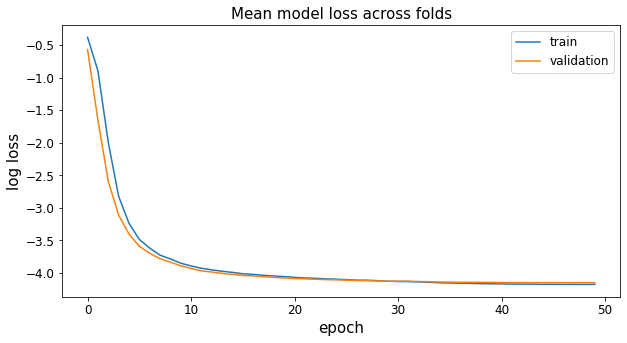

-----------------------------------------------------------------------
####################### Training for seed 5 ... #######################
****************************** Fold 1 ...******************************

Epoch 00035: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 00039: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.

Epoch 00042: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.

Epoch 00045: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.

Epoch 00048: ReduceLROnPlateau reducing learning rate to 3.200000264769187e-07.
Training score: loss of 0.01475547906011343; accuracy of 13.358879089355469%
Validation score: loss of 0.015531106851994991; accuracy of 12.34516054391861%
****************************** Fold 2 ...******************************

Epoch 00040: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 00044: ReduceLROnPlateau reducing learning rate to 4.000000

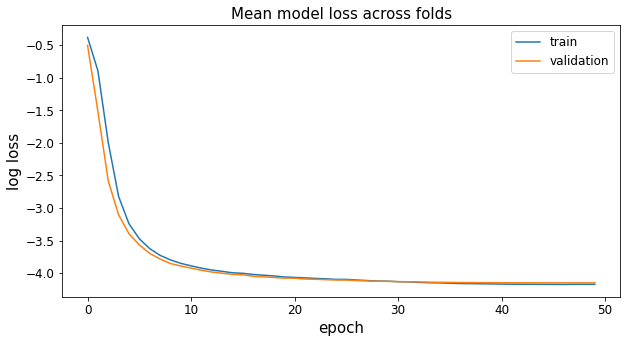

In [36]:
### K-fold cross validation

SEEDS = [1, 2, 3, 4, 5]
BATCH_SIZE = 512
NEPOCHS = 50

NFOLDS = 5

train_values = train.values
target_values = target.values

predictions_final = np.zeros((test_features.shape[0], len(targets_columns)))

for seed in SEEDS:

    print('-----------------------------------------------------------------------')
    print(f'####################### Training for seed {seed} ... #######################')
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
    predictions_test_fold = train_kfold(train_values, target_values, BATCH_SIZE, NEPOCHS, NFOLDS)
    predictions_final += predictions_test_fold / len(SEEDS)


## Predict & submit

In [37]:
# Neural Network
'''
usekfold=1

if ~usekfold:
    # make predictions
    to_predict=train_test[train_test['part']=='test'][train_features]
    predictions_final=nn.predict_proba(to_predict)
'''

sub_nn = pd.DataFrame(data=predictions_final, columns=targets_columns)
sub_nn.insert(0, column = 'sig_id', value=sample_submission['sig_id'])
sub_nn.to_csv('submission.csv',index=False)
sub_nn

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_0004d9e33,0.001196,0.001281,0.001438,0.013946,0.016255,0.004855,0.002915,0.007558,0.000976,...,0.000913,0.001205,0.003156,0.002857,0.001520,0.000928,0.001731,0.001900,0.002916,0.002250
1,id_001897cda,0.001479,0.001350,0.001662,0.002893,0.005176,0.002584,0.002514,0.004641,0.003338,...,0.001227,0.002121,0.001587,0.001819,0.014468,0.001279,0.026530,0.001683,0.001369,0.002012
2,id_002429b5b,0.000206,0.000189,0.000316,0.001427,0.000998,0.000248,0.000427,0.000360,0.000243,...,0.000220,0.000406,0.000396,0.000731,0.000425,0.000215,0.000570,0.000376,0.000252,0.000269
3,id_00276f245,0.000957,0.001171,0.001962,0.015663,0.011460,0.004095,0.003659,0.003021,0.000863,...,0.000993,0.002636,0.003341,0.039055,0.002850,0.000969,0.000876,0.002108,0.003273,0.002039
4,id_0027f1083,0.001480,0.001644,0.002117,0.019471,0.021731,0.004510,0.004267,0.004692,0.000888,...,0.001121,0.001749,0.004698,0.005521,0.001839,0.001110,0.001710,0.002100,0.003063,0.001861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3977,id_ff7004b87,0.001095,0.001422,0.001272,0.009553,0.014310,0.004698,0.002964,0.003636,0.000945,...,0.000842,0.002723,0.002738,0.068787,0.003897,0.000945,0.001696,0.001719,0.001651,0.001470
3978,id_ff925dd0d,0.002249,0.002236,0.001573,0.009315,0.018643,0.005530,0.004302,0.005405,0.001442,...,0.001147,0.001596,0.003914,0.002029,0.002447,0.001308,0.004542,0.001797,0.001895,0.001812
3979,id_ffb710450,0.001668,0.001597,0.001129,0.009312,0.026403,0.004609,0.003367,0.005511,0.000907,...,0.000764,0.000741,0.002871,0.001006,0.002291,0.000806,0.004291,0.001473,0.001518,0.001535
3980,id_ffbb869f2,0.001424,0.001461,0.001350,0.021353,0.025467,0.005798,0.003712,0.005605,0.000680,...,0.000729,0.000838,0.003852,0.001213,0.001132,0.000803,0.001063,0.001369,0.003546,0.002130


In [38]:
'''
# Random forest
# make predictions
to_predict=train_test[train_test['part']=='test'][train_features]

# restructure to match sample submission format
predictions = rf.predict_proba(to_predict)
predictions = [item[:,1] for item in predictions]
predictions = np.array(predictions)
predictions = np.transpose(predictions)
sub_rf = pd.DataFrame(data=predictions)
sub_rf.columns = targets_columns
sub_rf['sig_id'] = test_features['sig_id']
sub_rf = sub_rf[sample_submission.columns.tolist()]

# Set predictions for ctl_vehicle to zero
sub_rf['cp_type']=test_features['cp_type']
sub_rf.loc[sub_rf['cp_type']=='ctl_vehicle', targets_columns] = 0
del sub_rf['cp_type']
sub_rf.to_csv('submission.csv',index=False)
sub_rf
'''

"\n# Random forest\n# make predictions\nto_predict=train_test[train_test['part']=='test'][train_features]\n\n# restructure to match sample submission format\npredictions = rf.predict_proba(to_predict)\npredictions = [item[:,1] for item in predictions]\npredictions = np.array(predictions)\npredictions = np.transpose(predictions)\nsub_rf = pd.DataFrame(data=predictions)\nsub_rf.columns = targets_columns\nsub_rf['sig_id'] = test_features['sig_id']\nsub_rf = sub_rf[sample_submission.columns.tolist()]\n\n# Set predictions for ctl_vehicle to zero\nsub_rf['cp_type']=test_features['cp_type']\nsub_rf.loc[sub_rf['cp_type']=='ctl_vehicle', targets_columns] = 0\ndel sub_rf['cp_type']\nsub_rf.to_csv('submission.csv',index=False)\nsub_rf\n"